Step 1: Required Python Libraries

In [70]:
# Core LangGraph libraries
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
# LangChain tools and messages
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables.history import RunnableWithMessageHistory
# Pydantic for defining state
from pydantic import BaseModel, Field
# For typing and dictionaries
from typing import Dict, List, Optional, Union
# LangChain LLM (Groq with Mixtral or LLaMA3 etc.)
from langchain_groq import ChatGroq
# Memory store for message history (can be in-memory)
from langchain_community.chat_message_histories import FileChatMessageHistory
import os
from dotenv import load_dotenv


In [71]:
# Load environment variables
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:llama-3.1-8b-instant")

In [88]:
# =========================
# ✅ STATE CLASS DEFINITION (MODIFIED)
# =========================
class SupervisorState(BaseModel):
    current_agent: str                     
    task: str                              
    task_assignment: Dict[str, str] = {}   
    research_data: str = ""                
    analysis: str = ""                     
    report: str = ""                       
    summary: str = ""                      
    research_complete: bool = False  # NEW FLAG ADDED HERE

In [74]:
# ========================
# ✅ CEO Agent Definition
# ========================
def ceo_agent(state: SupervisorState) -> SupervisorState:
    task = state.task
    # Prepare CEO prompt
    prompt = f"""
You are the CEO of an AI research company.
Your job is to break down this task into subtasks for the Research Team Leader.
Task: {task}
Reply with:
1. The subtask to assign to Research Team Leader.
    """
    response = llm.invoke(prompt)
    subtask = response.content.strip()
    # Update state
    state.task_assignment["Research Team Leader"] = subtask
    state.current_agent = "Research Team Leader"  # Set next agent
    return state

In [89]:
# =====================================================
# Agent 1: Research Team Leader (Using Groq - Mixtral)
# =====================================================
def research_team_leader_agent(state: SupervisorState) -> SupervisorState:
    """Breaks the research task into two subtasks for Data and Market Researchers."""
    # Get the subtask from CEO
    research_task = state.task_assignment.get("Research Team Leader", "No task found.")
    if state.research_complete:
        state.current_agent = "writing_team_leader"
        return state
    # 🧠 Prompt to break task into two

    prompt = f"""
You are a Research Team Leader.
Your task is to divide the following research request into two focused subtasks:
1. A factual/statistical research task for a Data Researcher
2. A trends/market-oriented research task for a Market Researcher
Task: "{research_task}"
Reply in this exact format:
Data Researcher Task: <task>
Market Researcher Task: <task>
"""
# Invoke LLM
    response = llm.invoke([HumanMessage(content=prompt)])
    reply = response.content.strip()
    # Parse the reply (simple split)
    lines = reply.split("\n")
    data_task = ""
    market_task = ""
    for line in lines:
        if line.lower().startswith("data researcher task"):
            data_task = line.split(":", 1)[1].strip()
        elif line.lower().startswith("market researcher task"):
            market_task = line.split(":", 1)[1].strip()
    # Update state with subtasks
    state.task_assignment["Data Researcher"] = data_task
    state.task_assignment["Market Researcher"] = market_task
    state.current_agent = "Data Researcher"  # Start with Data Researcher
    return state

In [78]:
# =====================================================
# Agent 2: Data Researcher (Using Groq - Mixtral)
# =====================================================
def data_researcher_agent(state: SupervisorState) -> SupervisorState:
    """Data Researcher uses Groq to collect factual and statistical information."""
    # Get the specific subtask from Research Team Leader
    task = state.task_assignment.get("Data Researcher", "No data task found.")
    # 🧠 Create a factual/statistical research prompt
    prompt = f"""
You are a Data Researcher.
Please collect factual and statistical information on the following topic:
"{task}"
Include:
- Verified statistics and key data points
- Factual information from studies or reports
- Use bullet points for clarity
- Avoid opinions or marketing language
"""
# Call the LLM
    response = llm.invoke([HumanMessage(content=prompt)])
    research = response.content.strip()
    # 📝 Save results into research_data
    state.research_data += f"\n[Data Researcher Findings]\n{research}\n"
    state.current_agent = "Market Researcher"  # Go to next agent
    return state

In [79]:
# =====================================================
# Agent 3: Market Researcher (Using Groq - Mixtral)
# =====================================================
def market_researcher_agent(state: SupervisorState) -> SupervisorState:
    """Market Researcher uses Groq to find current trends and industry adoption."""
    # Get the market-oriented subtask
    task = state.task_assignment.get("Market Researcher", "No market research task provided.")
    # 🧠 Prompt for market trends, adoption, industry insights
    market_prompt = f"""
You are a Market Researcher.
Please conduct a qualitative market analysis on:
"{task}"
Include:
- Current trends and innovations
- Industry adoption levels
- Major companies or players
- Market challenges or opportunities
- Future outlook (next 5 years)

Write clearly and professionally.
"""
    # Call Groq LLM
    response = llm.invoke([HumanMessage(content=market_prompt)])
    market_research = response.content.strip()
    # 📝 Update the shared research data
    state.research_data += f"\n[Market Researcher Findings]\n{market_research}\n"
    state.current_agent = "Research Team Leader"  # Go back to team leader
    return state

In [80]:
# =====================================================
# Agent 4: Writing Team Leader
# =====================================================
def writing_team_leader_agent(state: SupervisorState) -> SupervisorState:
    """Writing Team Leader decides which writing agent to use or end the workflow."""
    task = state.task.lower()
    wants_technical = "technical" in task or "report" in task
    wants_summary = "summary" in task or "summarize" in task
    # If analysis is not yet available, the agent should not proceed
    if not state.analysis:
        print("Error: Analysis not available for Writing Team Leader.")
        state.current_agent = END  # Or some error handling state.
        return state
    # ✅ Decide next agent based on what’s missing
    if wants_technical and not state.report:
        state.current_agent = "Technical Writer"
    elif wants_summary and not state.summary:
        state.current_agent = "Summary Writer"
    else:
        print("✅ Writing complete. Returning control to CEO (END).")
        state.current_agent = END  # Indicate end of workflow
    return state

In [81]:
# =========================================================
# Agent 5: Technical Writer (Using Groq - Mixtral)
# =========================================================
def technical_writer_agent(state: SupervisorState) -> SupervisorState:
    """Technical Writer turns analysis into a formal technical report."""
    task = state.task
    analysis = state.analysis
    # 🧠 Prompt for professional technical report writing
    prompt = f"""
You are a professional technical writer.
Your task is to write a formal technical report based on the following analysis:
Task: "{task}"
Analysis:
{analysis}
Include:
- Introduction
- Detailed findings
- Use headings, bullet points, or numbered lists if appropriate
- Keep the tone professional, objective, and clear
"""
    # Call Groq LLM
    response = llm.invoke([HumanMessage(content=prompt)])
    report = response.content.strip()
    # 📝 Save to state
    state.report = report
    state.current_agent = "Writing Team Leader"  # Back to leader to decide next step
    return state

In [82]:
# =========================================================
# Agent 6: Summary Writer (Using Groq - Mixtral)
# =========================================================
def summary_writer_agent(state: SupervisorState) -> SupervisorState:
    """Summary Writer generates a concise summary from the research analysis."""
    task = state.task
    analysis = state.analysis
    # 🧠 Prompt for a summary
    prompt = f"""
You are a professional summary writer.
Your task is to write a clear and concise executive summary of the following analysis.
Task: "{task}"
Analysis:
{analysis}
Include:
- A short paragraph summarizing the key findings
- Use simple and direct language
- Avoid technical jargon
"""
    # Call Groq LLM
    response = llm.invoke([HumanMessage(content=prompt)])
    summary = response.content.strip()
    # 📝 Update state
    state.summary = summary
    state.current_agent = "Writing Team Leader"  # Go back to team leader to finish
    return state

In [84]:
# =====================================================
# ✅ Step 1: Create StateGraph
# =====================================================
# Create the graph with state type
workflow = StateGraph(SupervisorState)
# =====================================================
# ✅ Step 2: Add Agent Nodes
# =====================================================
workflow.add_node("ceo", ceo_agent)
workflow.add_node("research_team_leader", research_team_leader_agent)
workflow.add_node("data_researcher", data_researcher_agent)
workflow.add_node("market_researcher", market_researcher_agent)
workflow.add_node("writing_team_leader", writing_team_leader_agent)
workflow.add_node("technical_writer", technical_writer_agent)
workflow.add_node("summary_writer", summary_writer_agent)
# =====================================================
# ✅ Step 3: Set Entry Point
# =====================================================
workflow.set_entry_point("ceo")
# =====================================================
# ✅ Step 4: Add Edges (Flow Control using conditional logic)
# =====================================================
# After CEO, transition based on current_agent set by CEO
workflow.add_conditional_edges(
    "ceo",
    lambda state: state.current_agent,  # Function to determine the next path
    {
        "Research Team Leader": "research_team_leader"  # Mapping: key returned by lambda -> node name
    }
)
# After Research Team Leader, transition based on current_agent
workflow.add_conditional_edges(
    "research_team_leader",
    lambda state: state.current_agent,
    {
        "Data Researcher": "data_researcher",
        "Writing Team Leader": "writing_team_leader"  # RTL might decide to go to writing if research is deemed sufficient
    }
)
# After Data Researcher, transition to Market Researcher
workflow.add_conditional_edges(
    "data_researcher",
    lambda state: state.current_agent,
    {
        "Market Researcher": "market_researcher"
    }
)
# After Market Researcher, transition back to Research Team Leader
workflow.add_conditional_edges(
    "market_researcher",
    lambda state: state.current_agent,
    {
        "Research Team Leader": "research_team_leader"
    }
)
# After Writing Team Leader, transition to Technical Writer, Summary Writer, or END
workflow.add_conditional_edges(
    "writing_team_leader",
    lambda state: state.current_agent,
    {
        "Technical Writer": "technical_writer",
        "Summary Writer": "summary_writer",
        END: END  # Explicitly define END as a possible transition
    }
)
# After Technical Writer, transition back to Writing Team Leader
workflow.add_conditional_edges(
    "technical_writer",
    lambda state: state.current_agent,
    {
        "Writing Team Leader": "writing_team_leader"
    }
)
# After Summary Writer, transition back to Writing Team Leader
workflow.add_conditional_edges(
    "summary_writer",
    lambda state: state.current_agent,
    {
        "Writing Team Leader": "writing_team_leader"
    }
)

In [85]:
# =====================================================
# ✅ Step 5: Compile the Graph
# =====================================================
app = workflow.compile()

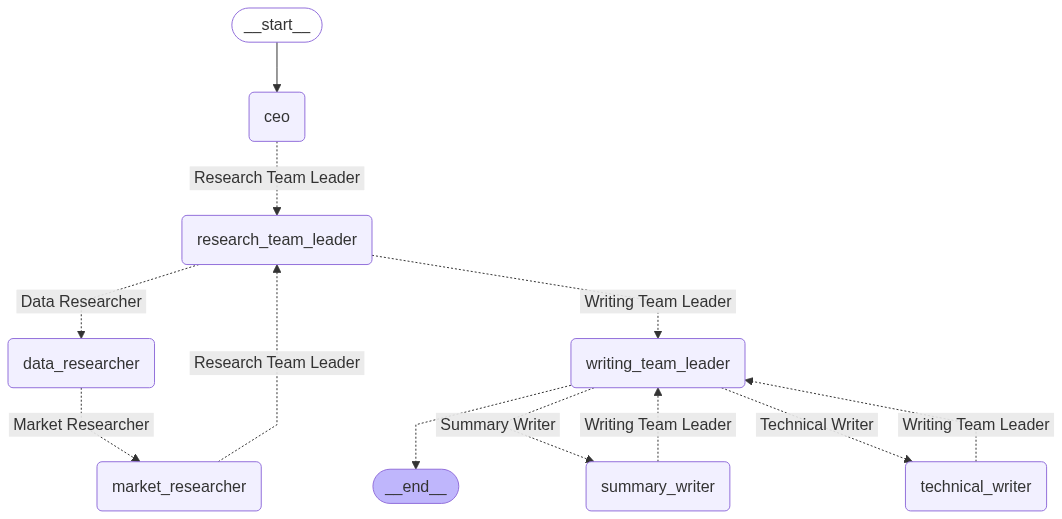

In [86]:
app

In [87]:
# =====================================================
# ✅ Step 6: Invoke the Graph (Corrected)
# =====================================================
# Invoke with the initial state as a dictionary
response = app.invoke(
    {
        "current_agent": "ceo",  # Initial agent (corrected to lowercase)
        "task": "What are the benefits and risks of AI in healthcare? Make a technical report on it"  # Initial task
    }
)
# Access the results from the final state
print("Generated Report:\n", response.get("report", "No report generated."))
print("\nGenerated Summary:\n", response.get("summary", "No summary generated."))

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT